In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import xgboost
import seaborn as sns
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
#drough_features = pd.read_csv(f'{GENERAL_PATH}drought_data_features.csv', index_col=0)
#meteorological_features = pd.read_csv(f'{GENERAL_PATH}meteorological_data_features.csv', index_col=0)
#neighbour_features = pd.read_csv(f'{GENERAL_PATH}drought_data_neighbour_features.csv', index_col=0)
#targets = pd.read_csv(f'{GENERAL_PATH}drought_data_targets.csv', index_col=0)
#additional_data = pd.read_csv(f'{GENERAL_PATH}drought_data.csv', index_col=0)

In [3]:
all_features = pd.read_parquet('../data/interim/drought_data_features2024.parquet')
targets = pd.read_parquet('../data/interim/drought_data_targets2024.parquet')
additional_data = pd.read_parquet('../data/interim/drought_data_info2024.parquet')

In [4]:
target = 'DROUGHT_INDEX__NEXT_6MONTHS'

In [5]:
additional_data.DATE = pd.to_datetime(additional_data.DATE)
#additional_data.NEW_DATE = pd.to_datetime(additional_data.NEW_DATE)

In [6]:
ix_features = additional_data[(additional_data.DATE > pd.to_datetime('2016-01-15') + datetime.timedelta(150-15*1))].index
ix_targets = targets[targets.DROUGHT_INDEX__NEXT_6MONTHS.notna()].index

ix = pd.Index(set(ix_features).intersection(ix_targets))
usable_features = all_features.loc[ix]
usable_targets = targets.loc[ix]

In [7]:
#additional_data.loc[all_features[all_features.di_neighbour_group__mean_last180_days_same_cve__mean.isna()].index].CVE_CONCATENADA.value_counts()

In [8]:
#available_features = all_features[all_features.isna().sum()[all_features.isna().sum()<300000].index]
#available_features = available_features[available_features.isna().sum(axis=1) < 88]

In [9]:
available_targets = targets[targets[target].notna()]

In [10]:
X = usable_features
y =(usable_targets[target] > 2).astype(int)

available_data = additional_data.loc[ix]
MIN_DATE_INFO = available_data.DATE.min()
MAX_DATE_INFO = available_data.DATE.max()

PROPOSED_DATE = pd.to_datetime('2023-01-01')

In [11]:
MIN_DATE_INFO, MAX_DATE_INFO

(Timestamp('2016-06-15 00:00:00'), Timestamp('2023-05-28 00:00:00'))

In [12]:
train_window = available_data[
    available_data.DATE.between(MIN_DATE_INFO, PROPOSED_DATE)
].index

oot_window = available_data[
    available_data.DATE.between(PROPOSED_DATE, MAX_DATE_INFO)
].index

In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    X.loc[train_window], 
    y.loc[train_window], 
    train_size=0.9)

x_oot, y_oot = X.loc[oot_window], y.loc[oot_window]

x_oot, x_dev, y_oot, y_dev = train_test_split(
    x_oot, 
    y_oot, 
    train_size=0.5)

In [14]:
del X
del y

In [16]:
scale_pos_weight = (y_train == 0).sum()/(y_train == 1).sum()

55.65292876845692

In [19]:
params = {
    'n_estimators':10000,
    'max_depth':6,
    'gamma':0.4,
    'learning_rate': 0.001,
    'subsample':0.8,
    'colsample_bytree': 0.8,
    'colsample_bylevel':0.8,
    'colsample_bynode':0.8,
    'reg_alpha':10,
    'reg_lambda':10,
    'scale_pos_weight': scale_pos_weight, 
    'base_score':0.5, 
    'random_state': 42,
    'eval_metric': ['aucpr', 'auc', 'logloss'],
    'early_stopping_rounds': 3,
}

In [20]:
model = xgboost.XGBClassifier(**params)
model.fit(
    x_train, 
    y_train, 
    eval_set=[(x_train, y_train), (x_dev, y_dev)], 
)

[0]	validation_0-aucpr:0.09384	validation_0-auc:0.84819	validation_0-logloss:0.69277	validation_1-aucpr:0.26757	validation_1-auc:0.64911	validation_1-logloss:0.69293
[1]	validation_0-aucpr:0.11469	validation_0-auc:0.86751	validation_0-logloss:0.69239	validation_1-aucpr:0.27666	validation_1-auc:0.68687	validation_1-logloss:0.69271
[2]	validation_0-aucpr:0.13417	validation_0-auc:0.87733	validation_0-logloss:0.69201	validation_1-aucpr:0.27334	validation_1-auc:0.69168	validation_1-logloss:0.69247
[3]	validation_0-aucpr:0.13843	validation_0-auc:0.87698	validation_0-logloss:0.69164	validation_1-aucpr:0.27448	validation_1-auc:0.69416	validation_1-logloss:0.69224
[4]	validation_0-aucpr:0.14431	validation_0-auc:0.88048	validation_0-logloss:0.69126	validation_1-aucpr:0.27125	validation_1-auc:0.68842	validation_1-logloss:0.69204
[5]	validation_0-aucpr:0.14931	validation_0-auc:0.88501	validation_0-logloss:0.69087	validation_1-aucpr:0.27353	validation_1-auc:0.69516	validation_1-logloss:0.69178
[6]	

[50]	validation_0-aucpr:0.18791	validation_0-auc:0.89633	validation_0-logloss:0.67438	validation_1-aucpr:0.27486	validation_1-auc:0.70413	validation_1-logloss:0.68160
[51]	validation_0-aucpr:0.18717	validation_0-auc:0.89634	validation_0-logloss:0.67403	validation_1-aucpr:0.27468	validation_1-auc:0.70399	validation_1-logloss:0.68139
[52]	validation_0-aucpr:0.18926	validation_0-auc:0.89648	validation_0-logloss:0.67368	validation_1-aucpr:0.27452	validation_1-auc:0.70389	validation_1-logloss:0.68116
[53]	validation_0-aucpr:0.18885	validation_0-auc:0.89651	validation_0-logloss:0.67333	validation_1-aucpr:0.27489	validation_1-auc:0.70428	validation_1-logloss:0.68096
[54]	validation_0-aucpr:0.18892	validation_0-auc:0.89651	validation_0-logloss:0.67298	validation_1-aucpr:0.27481	validation_1-auc:0.70387	validation_1-logloss:0.68076
[55]	validation_0-aucpr:0.19047	validation_0-auc:0.89645	validation_0-logloss:0.67264	validation_1-aucpr:0.27472	validation_1-auc:0.70392	validation_1-logloss:0.6805

[100]	validation_0-aucpr:0.19604	validation_0-auc:0.89882	validation_0-logloss:0.65754	validation_1-aucpr:0.27488	validation_1-auc:0.70416	validation_1-logloss:0.67171
[101]	validation_0-aucpr:0.19601	validation_0-auc:0.89891	validation_0-logloss:0.65721	validation_1-aucpr:0.27486	validation_1-auc:0.70412	validation_1-logloss:0.67152
[102]	validation_0-aucpr:0.19588	validation_0-auc:0.89912	validation_0-logloss:0.65687	validation_1-aucpr:0.27488	validation_1-auc:0.70407	validation_1-logloss:0.67135
[103]	validation_0-aucpr:0.19598	validation_0-auc:0.89908	validation_0-logloss:0.65654	validation_1-aucpr:0.27491	validation_1-auc:0.70414	validation_1-logloss:0.67116
[104]	validation_0-aucpr:0.19559	validation_0-auc:0.89906	validation_0-logloss:0.65621	validation_1-aucpr:0.27466	validation_1-auc:0.70373	validation_1-logloss:0.67097
[105]	validation_0-aucpr:0.19529	validation_0-auc:0.89903	validation_0-logloss:0.65590	validation_1-aucpr:0.27450	validation_1-auc:0.70365	validation_1-logloss:

[149]	validation_0-aucpr:0.19993	validation_0-auc:0.89992	validation_0-logloss:0.64219	validation_1-aucpr:0.27392	validation_1-auc:0.70303	validation_1-logloss:0.66257
[150]	validation_0-aucpr:0.19968	validation_0-auc:0.89984	validation_0-logloss:0.64190	validation_1-aucpr:0.27378	validation_1-auc:0.70281	validation_1-logloss:0.66242
[151]	validation_0-aucpr:0.19939	validation_0-auc:0.89980	validation_0-logloss:0.64161	validation_1-aucpr:0.27389	validation_1-auc:0.70294	validation_1-logloss:0.66225
[152]	validation_0-aucpr:0.19901	validation_0-auc:0.89978	validation_0-logloss:0.64133	validation_1-aucpr:0.27389	validation_1-auc:0.70298	validation_1-logloss:0.66207
[153]	validation_0-aucpr:0.19989	validation_0-auc:0.89975	validation_0-logloss:0.64103	validation_1-aucpr:0.27410	validation_1-auc:0.70320	validation_1-logloss:0.66188
[154]	validation_0-aucpr:0.19985	validation_0-auc:0.89983	validation_0-logloss:0.64073	validation_1-aucpr:0.27401	validation_1-auc:0.70300	validation_1-logloss:

[198]	validation_0-aucpr:0.20301	validation_0-auc:0.90107	validation_0-logloss:0.62806	validation_1-aucpr:0.27396	validation_1-auc:0.70343	validation_1-logloss:0.65407
[199]	validation_0-aucpr:0.20347	validation_0-auc:0.90104	validation_0-logloss:0.62778	validation_1-aucpr:0.27399	validation_1-auc:0.70349	validation_1-logloss:0.65391
[200]	validation_0-aucpr:0.20361	validation_0-auc:0.90103	validation_0-logloss:0.62753	validation_1-aucpr:0.27393	validation_1-auc:0.70339	validation_1-logloss:0.65376
[201]	validation_0-aucpr:0.20334	validation_0-auc:0.90105	validation_0-logloss:0.62724	validation_1-aucpr:0.27386	validation_1-auc:0.70330	validation_1-logloss:0.65358
[202]	validation_0-aucpr:0.20308	validation_0-auc:0.90107	validation_0-logloss:0.62696	validation_1-aucpr:0.27380	validation_1-auc:0.70316	validation_1-logloss:0.65342
[203]	validation_0-aucpr:0.20322	validation_0-auc:0.90110	validation_0-logloss:0.62668	validation_1-aucpr:0.27394	validation_1-auc:0.70331	validation_1-logloss:

[247]	validation_0-aucpr:0.20747	validation_0-auc:0.90247	validation_0-logloss:0.61485	validation_1-aucpr:0.27421	validation_1-auc:0.70324	validation_1-logloss:0.64628
[248]	validation_0-aucpr:0.20778	validation_0-auc:0.90246	validation_0-logloss:0.61460	validation_1-aucpr:0.27416	validation_1-auc:0.70320	validation_1-logloss:0.64613
[249]	validation_0-aucpr:0.20782	validation_0-auc:0.90247	validation_0-logloss:0.61435	validation_1-aucpr:0.27404	validation_1-auc:0.70304	validation_1-logloss:0.64598
[250]	validation_0-aucpr:0.20818	validation_0-auc:0.90247	validation_0-logloss:0.61409	validation_1-aucpr:0.27410	validation_1-auc:0.70305	validation_1-logloss:0.64583
[251]	validation_0-aucpr:0.20803	validation_0-auc:0.90256	validation_0-logloss:0.61382	validation_1-aucpr:0.27418	validation_1-auc:0.70316	validation_1-logloss:0.64565
[252]	validation_0-aucpr:0.20797	validation_0-auc:0.90253	validation_0-logloss:0.61357	validation_1-aucpr:0.27411	validation_1-auc:0.70304	validation_1-logloss:

[296]	validation_0-aucpr:0.20992	validation_0-auc:0.90342	validation_0-logloss:0.60255	validation_1-aucpr:0.27431	validation_1-auc:0.70307	validation_1-logloss:0.63895
[297]	validation_0-aucpr:0.20974	validation_0-auc:0.90342	validation_0-logloss:0.60232	validation_1-aucpr:0.27425	validation_1-auc:0.70300	validation_1-logloss:0.63883
[298]	validation_0-aucpr:0.20952	validation_0-auc:0.90341	validation_0-logloss:0.60208	validation_1-aucpr:0.27425	validation_1-auc:0.70307	validation_1-logloss:0.63867
[299]	validation_0-aucpr:0.20939	validation_0-auc:0.90342	validation_0-logloss:0.60183	validation_1-aucpr:0.27431	validation_1-auc:0.70320	validation_1-logloss:0.63851
[300]	validation_0-aucpr:0.20973	validation_0-auc:0.90341	validation_0-logloss:0.60160	validation_1-aucpr:0.27431	validation_1-auc:0.70314	validation_1-logloss:0.63838
[301]	validation_0-aucpr:0.20992	validation_0-auc:0.90339	validation_0-logloss:0.60137	validation_1-aucpr:0.27424	validation_1-auc:0.70305	validation_1-logloss:

[345]	validation_0-aucpr:0.21248	validation_0-auc:0.90418	validation_0-logloss:0.59105	validation_1-aucpr:0.27309	validation_1-auc:0.70166	validation_1-logloss:0.63266
[346]	validation_0-aucpr:0.21226	validation_0-auc:0.90426	validation_0-logloss:0.59081	validation_1-aucpr:0.27312	validation_1-auc:0.70166	validation_1-logloss:0.63252
[347]	validation_0-aucpr:0.21209	validation_0-auc:0.90430	validation_0-logloss:0.59058	validation_1-aucpr:0.27314	validation_1-auc:0.70167	validation_1-logloss:0.63236
[348]	validation_0-aucpr:0.21207	validation_0-auc:0.90432	validation_0-logloss:0.59035	validation_1-aucpr:0.27310	validation_1-auc:0.70162	validation_1-logloss:0.63224
[349]	validation_0-aucpr:0.21236	validation_0-auc:0.90439	validation_0-logloss:0.59011	validation_1-aucpr:0.27301	validation_1-auc:0.70151	validation_1-logloss:0.63212
[350]	validation_0-aucpr:0.21231	validation_0-auc:0.90439	validation_0-logloss:0.58990	validation_1-aucpr:0.27298	validation_1-auc:0.70145	validation_1-logloss:

[394]	validation_0-aucpr:0.21515	validation_0-auc:0.90544	validation_0-logloss:0.58015	validation_1-aucpr:0.27280	validation_1-auc:0.70116	validation_1-logloss:0.62667
[395]	validation_0-aucpr:0.21501	validation_0-auc:0.90542	validation_0-logloss:0.57995	validation_1-aucpr:0.27279	validation_1-auc:0.70119	validation_1-logloss:0.62656
[396]	validation_0-aucpr:0.21497	validation_0-auc:0.90547	validation_0-logloss:0.57972	validation_1-aucpr:0.27275	validation_1-auc:0.70114	validation_1-logloss:0.62643
[397]	validation_0-aucpr:0.21499	validation_0-auc:0.90546	validation_0-logloss:0.57952	validation_1-aucpr:0.27269	validation_1-auc:0.70103	validation_1-logloss:0.62633
[398]	validation_0-aucpr:0.21503	validation_0-auc:0.90548	validation_0-logloss:0.57931	validation_1-aucpr:0.27261	validation_1-auc:0.70091	validation_1-logloss:0.62624
[399]	validation_0-aucpr:0.21504	validation_0-auc:0.90550	validation_0-logloss:0.57910	validation_1-aucpr:0.27257	validation_1-auc:0.70088	validation_1-logloss:

[443]	validation_0-aucpr:0.21568	validation_0-auc:0.90625	validation_0-logloss:0.57011	validation_1-aucpr:0.27177	validation_1-auc:0.69978	validation_1-logloss:0.62138
[444]	validation_0-aucpr:0.21566	validation_0-auc:0.90626	validation_0-logloss:0.56990	validation_1-aucpr:0.27177	validation_1-auc:0.69979	validation_1-logloss:0.62128
[445]	validation_0-aucpr:0.21568	validation_0-auc:0.90630	validation_0-logloss:0.56969	validation_1-aucpr:0.27176	validation_1-auc:0.69984	validation_1-logloss:0.62119
[446]	validation_0-aucpr:0.21569	validation_0-auc:0.90631	validation_0-logloss:0.56950	validation_1-aucpr:0.27179	validation_1-auc:0.69988	validation_1-logloss:0.62110
[447]	validation_0-aucpr:0.21603	validation_0-auc:0.90636	validation_0-logloss:0.56929	validation_1-aucpr:0.27185	validation_1-auc:0.69994	validation_1-logloss:0.62098
[448]	validation_0-aucpr:0.21609	validation_0-auc:0.90639	validation_0-logloss:0.56909	validation_1-aucpr:0.27191	validation_1-auc:0.69999	validation_1-logloss:

[492]	validation_0-aucpr:0.22005	validation_0-auc:0.90729	validation_0-logloss:0.56053	validation_1-aucpr:0.27178	validation_1-auc:0.69987	validation_1-logloss:0.61621
[493]	validation_0-aucpr:0.22008	validation_0-auc:0.90734	validation_0-logloss:0.56033	validation_1-aucpr:0.27179	validation_1-auc:0.69989	validation_1-logloss:0.61610
[494]	validation_0-aucpr:0.21982	validation_0-auc:0.90734	validation_0-logloss:0.56016	validation_1-aucpr:0.27181	validation_1-auc:0.69996	validation_1-logloss:0.61600
[495]	validation_0-aucpr:0.21976	validation_0-auc:0.90739	validation_0-logloss:0.55996	validation_1-aucpr:0.27178	validation_1-auc:0.69989	validation_1-logloss:0.61590
[496]	validation_0-aucpr:0.21963	validation_0-auc:0.90739	validation_0-logloss:0.55979	validation_1-aucpr:0.27174	validation_1-auc:0.69983	validation_1-logloss:0.61583
[497]	validation_0-aucpr:0.21977	validation_0-auc:0.90739	validation_0-logloss:0.55960	validation_1-aucpr:0.27180	validation_1-auc:0.69987	validation_1-logloss:

[541]	validation_0-aucpr:0.22150	validation_0-auc:0.90840	validation_0-logloss:0.55151	validation_1-aucpr:0.27132	validation_1-auc:0.69920	validation_1-logloss:0.61143
[542]	validation_0-aucpr:0.22171	validation_0-auc:0.90841	validation_0-logloss:0.55134	validation_1-aucpr:0.27131	validation_1-auc:0.69921	validation_1-logloss:0.61134
[543]	validation_0-aucpr:0.22179	validation_0-auc:0.90845	validation_0-logloss:0.55116	validation_1-aucpr:0.27128	validation_1-auc:0.69915	validation_1-logloss:0.61127
[544]	validation_0-aucpr:0.22205	validation_0-auc:0.90847	validation_0-logloss:0.55098	validation_1-aucpr:0.27129	validation_1-auc:0.69919	validation_1-logloss:0.61117
[545]	validation_0-aucpr:0.22234	validation_0-auc:0.90853	validation_0-logloss:0.55079	validation_1-aucpr:0.27126	validation_1-auc:0.69919	validation_1-logloss:0.61106
[546]	validation_0-aucpr:0.22281	validation_0-auc:0.90856	validation_0-logloss:0.55062	validation_1-aucpr:0.27120	validation_1-auc:0.69909	validation_1-logloss:

[590]	validation_0-aucpr:0.22578	validation_0-auc:0.90977	validation_0-logloss:0.54289	validation_1-aucpr:0.27100	validation_1-auc:0.69874	validation_1-logloss:0.60696
[591]	validation_0-aucpr:0.22575	validation_0-auc:0.90979	validation_0-logloss:0.54274	validation_1-aucpr:0.27102	validation_1-auc:0.69880	validation_1-logloss:0.60687
[592]	validation_0-aucpr:0.22570	validation_0-auc:0.90979	validation_0-logloss:0.54258	validation_1-aucpr:0.27098	validation_1-auc:0.69873	validation_1-logloss:0.60682
[593]	validation_0-aucpr:0.22585	validation_0-auc:0.90981	validation_0-logloss:0.54241	validation_1-aucpr:0.27099	validation_1-auc:0.69877	validation_1-logloss:0.60672
[594]	validation_0-aucpr:0.22602	validation_0-auc:0.90983	validation_0-logloss:0.54223	validation_1-aucpr:0.27101	validation_1-auc:0.69882	validation_1-logloss:0.60662
[595]	validation_0-aucpr:0.22613	validation_0-auc:0.90987	validation_0-logloss:0.54207	validation_1-aucpr:0.27099	validation_1-auc:0.69878	validation_1-logloss:

[639]	validation_0-aucpr:0.23016	validation_0-auc:0.91080	validation_0-logloss:0.53488	validation_1-aucpr:0.27045	validation_1-auc:0.69812	validation_1-logloss:0.60303
[640]	validation_0-aucpr:0.23016	validation_0-auc:0.91082	validation_0-logloss:0.53473	validation_1-aucpr:0.27044	validation_1-auc:0.69812	validation_1-logloss:0.60295
[641]	validation_0-aucpr:0.23032	validation_0-auc:0.91084	validation_0-logloss:0.53456	validation_1-aucpr:0.27045	validation_1-auc:0.69812	validation_1-logloss:0.60286
[642]	validation_0-aucpr:0.23075	validation_0-auc:0.91085	validation_0-logloss:0.53442	validation_1-aucpr:0.27045	validation_1-auc:0.69816	validation_1-logloss:0.60279
[643]	validation_0-aucpr:0.23097	validation_0-auc:0.91088	validation_0-logloss:0.53427	validation_1-aucpr:0.27043	validation_1-auc:0.69811	validation_1-logloss:0.60274
[644]	validation_0-aucpr:0.23093	validation_0-auc:0.91090	validation_0-logloss:0.53409	validation_1-aucpr:0.27045	validation_1-auc:0.69813	validation_1-logloss:

[688]	validation_0-aucpr:0.23330	validation_0-auc:0.91194	validation_0-logloss:0.52722	validation_1-aucpr:0.27050	validation_1-auc:0.69854	validation_1-logloss:0.59915
[689]	validation_0-aucpr:0.23366	validation_0-auc:0.91194	validation_0-logloss:0.52708	validation_1-aucpr:0.27049	validation_1-auc:0.69855	validation_1-logloss:0.59907
[690]	validation_0-aucpr:0.23385	validation_0-auc:0.91195	validation_0-logloss:0.52692	validation_1-aucpr:0.27047	validation_1-auc:0.69853	validation_1-logloss:0.59900
[691]	validation_0-aucpr:0.23400	validation_0-auc:0.91200	validation_0-logloss:0.52676	validation_1-aucpr:0.27049	validation_1-auc:0.69851	validation_1-logloss:0.59895
[692]	validation_0-aucpr:0.23396	validation_0-auc:0.91203	validation_0-logloss:0.52659	validation_1-aucpr:0.27050	validation_1-auc:0.69854	validation_1-logloss:0.59885
[693]	validation_0-aucpr:0.23395	validation_0-auc:0.91206	validation_0-logloss:0.52644	validation_1-aucpr:0.27054	validation_1-auc:0.69862	validation_1-logloss:

[737]	validation_0-aucpr:0.23728	validation_0-auc:0.91320	validation_0-logloss:0.51989	validation_1-aucpr:0.27017	validation_1-auc:0.69837	validation_1-logloss:0.59548
[738]	validation_0-aucpr:0.23734	validation_0-auc:0.91318	validation_0-logloss:0.51975	validation_1-aucpr:0.27016	validation_1-auc:0.69831	validation_1-logloss:0.59543
[739]	validation_0-aucpr:0.23740	validation_0-auc:0.91320	validation_0-logloss:0.51963	validation_1-aucpr:0.27013	validation_1-auc:0.69829	validation_1-logloss:0.59538
[740]	validation_0-aucpr:0.23740	validation_0-auc:0.91325	validation_0-logloss:0.51950	validation_1-aucpr:0.27015	validation_1-auc:0.69831	validation_1-logloss:0.59531
[741]	validation_0-aucpr:0.23743	validation_0-auc:0.91326	validation_0-logloss:0.51935	validation_1-aucpr:0.27014	validation_1-auc:0.69828	validation_1-logloss:0.59525
[742]	validation_0-aucpr:0.23761	validation_0-auc:0.91326	validation_0-logloss:0.51921	validation_1-aucpr:0.27012	validation_1-auc:0.69826	validation_1-logloss:

[786]	validation_0-aucpr:0.23968	validation_0-auc:0.91417	validation_0-logloss:0.51309	validation_1-aucpr:0.27021	validation_1-auc:0.69834	validation_1-logloss:0.59237
[787]	validation_0-aucpr:0.23966	validation_0-auc:0.91420	validation_0-logloss:0.51295	validation_1-aucpr:0.27022	validation_1-auc:0.69837	validation_1-logloss:0.59230
[788]	validation_0-aucpr:0.23974	validation_0-auc:0.91423	validation_0-logloss:0.51282	validation_1-aucpr:0.27022	validation_1-auc:0.69837	validation_1-logloss:0.59222
[789]	validation_0-aucpr:0.23977	validation_0-auc:0.91427	validation_0-logloss:0.51267	validation_1-aucpr:0.27026	validation_1-auc:0.69842	validation_1-logloss:0.59213
[790]	validation_0-aucpr:0.23982	validation_0-auc:0.91430	validation_0-logloss:0.51253	validation_1-aucpr:0.27028	validation_1-auc:0.69845	validation_1-logloss:0.59205
[791]	validation_0-aucpr:0.23999	validation_0-auc:0.91431	validation_0-logloss:0.51239	validation_1-aucpr:0.27026	validation_1-auc:0.69845	validation_1-logloss:

[835]	validation_0-aucpr:0.24258	validation_0-auc:0.91522	validation_0-logloss:0.50659	validation_1-aucpr:0.27012	validation_1-auc:0.69829	validation_1-logloss:0.58936
[836]	validation_0-aucpr:0.24260	validation_0-auc:0.91523	validation_0-logloss:0.50647	validation_1-aucpr:0.27013	validation_1-auc:0.69829	validation_1-logloss:0.58930
[837]	validation_0-aucpr:0.24268	validation_0-auc:0.91522	validation_0-logloss:0.50634	validation_1-aucpr:0.27010	validation_1-auc:0.69827	validation_1-logloss:0.58924
[838]	validation_0-aucpr:0.24270	validation_0-auc:0.91522	validation_0-logloss:0.50622	validation_1-aucpr:0.27009	validation_1-auc:0.69827	validation_1-logloss:0.58920
[839]	validation_0-aucpr:0.24290	validation_0-auc:0.91525	validation_0-logloss:0.50610	validation_1-aucpr:0.27013	validation_1-auc:0.69829	validation_1-logloss:0.58912
[840]	validation_0-aucpr:0.24302	validation_0-auc:0.91527	validation_0-logloss:0.50597	validation_1-aucpr:0.27016	validation_1-auc:0.69830	validation_1-logloss:

[884]	validation_0-aucpr:0.24487	validation_0-auc:0.91636	validation_0-logloss:0.50024	validation_1-aucpr:0.27004	validation_1-auc:0.69825	validation_1-logloss:0.58635
[885]	validation_0-aucpr:0.24498	validation_0-auc:0.91638	validation_0-logloss:0.50011	validation_1-aucpr:0.27004	validation_1-auc:0.69822	validation_1-logloss:0.58629
[886]	validation_0-aucpr:0.24519	validation_0-auc:0.91641	validation_0-logloss:0.49999	validation_1-aucpr:0.27002	validation_1-auc:0.69820	validation_1-logloss:0.58622
[887]	validation_0-aucpr:0.24512	validation_0-auc:0.91642	validation_0-logloss:0.49986	validation_1-aucpr:0.27000	validation_1-auc:0.69817	validation_1-logloss:0.58615
[888]	validation_0-aucpr:0.24522	validation_0-auc:0.91642	validation_0-logloss:0.49975	validation_1-aucpr:0.26999	validation_1-auc:0.69814	validation_1-logloss:0.58610
[889]	validation_0-aucpr:0.24527	validation_0-auc:0.91647	validation_0-logloss:0.49961	validation_1-aucpr:0.27000	validation_1-auc:0.69817	validation_1-logloss:

[933]	validation_0-aucpr:0.24771	validation_0-auc:0.91755	validation_0-logloss:0.49418	validation_1-aucpr:0.27012	validation_1-auc:0.69827	validation_1-logloss:0.58361
[934]	validation_0-aucpr:0.24775	validation_0-auc:0.91757	validation_0-logloss:0.49407	validation_1-aucpr:0.27009	validation_1-auc:0.69824	validation_1-logloss:0.58357
[935]	validation_0-aucpr:0.24776	validation_0-auc:0.91758	validation_0-logloss:0.49395	validation_1-aucpr:0.27007	validation_1-auc:0.69822	validation_1-logloss:0.58352
[936]	validation_0-aucpr:0.24769	validation_0-auc:0.91760	validation_0-logloss:0.49384	validation_1-aucpr:0.27005	validation_1-auc:0.69821	validation_1-logloss:0.58348
[937]	validation_0-aucpr:0.24779	validation_0-auc:0.91762	validation_0-logloss:0.49372	validation_1-aucpr:0.27002	validation_1-auc:0.69819	validation_1-logloss:0.58343
[938]	validation_0-aucpr:0.24775	validation_0-auc:0.91764	validation_0-logloss:0.49360	validation_1-aucpr:0.27003	validation_1-auc:0.69822	validation_1-logloss:

[982]	validation_0-aucpr:0.25061	validation_0-auc:0.91874	validation_0-logloss:0.48849	validation_1-aucpr:0.26992	validation_1-auc:0.69812	validation_1-logloss:0.58104
[983]	validation_0-aucpr:0.25061	validation_0-auc:0.91875	validation_0-logloss:0.48837	validation_1-aucpr:0.26992	validation_1-auc:0.69811	validation_1-logloss:0.58101
[984]	validation_0-aucpr:0.25078	validation_0-auc:0.91877	validation_0-logloss:0.48826	validation_1-aucpr:0.26994	validation_1-auc:0.69816	validation_1-logloss:0.58093
[985]	validation_0-aucpr:0.25098	validation_0-auc:0.91882	validation_0-logloss:0.48814	validation_1-aucpr:0.26996	validation_1-auc:0.69821	validation_1-logloss:0.58085
[986]	validation_0-aucpr:0.25103	validation_0-auc:0.91881	validation_0-logloss:0.48804	validation_1-aucpr:0.26994	validation_1-auc:0.69821	validation_1-logloss:0.58081
[987]	validation_0-aucpr:0.25116	validation_0-auc:0.91885	validation_0-logloss:0.48792	validation_1-aucpr:0.26993	validation_1-auc:0.69820	validation_1-logloss:

[1031]	validation_0-aucpr:0.25428	validation_0-auc:0.91985	validation_0-logloss:0.48302	validation_1-aucpr:0.27007	validation_1-auc:0.69834	validation_1-logloss:0.57848
[1032]	validation_0-aucpr:0.25429	validation_0-auc:0.91987	validation_0-logloss:0.48290	validation_1-aucpr:0.27006	validation_1-auc:0.69833	validation_1-logloss:0.57843
[1033]	validation_0-aucpr:0.25444	validation_0-auc:0.91991	validation_0-logloss:0.48279	validation_1-aucpr:0.27008	validation_1-auc:0.69835	validation_1-logloss:0.57837
[1034]	validation_0-aucpr:0.25446	validation_0-auc:0.91993	validation_0-logloss:0.48269	validation_1-aucpr:0.27006	validation_1-auc:0.69833	validation_1-logloss:0.57832
[1035]	validation_0-aucpr:0.25450	validation_0-auc:0.91995	validation_0-logloss:0.48258	validation_1-aucpr:0.27004	validation_1-auc:0.69829	validation_1-logloss:0.57827
[1036]	validation_0-aucpr:0.25462	validation_0-auc:0.91998	validation_0-logloss:0.48247	validation_1-aucpr:0.27007	validation_1-auc:0.69831	validation_1-lo

[1080]	validation_0-aucpr:0.25748	validation_0-auc:0.92084	validation_0-logloss:0.47781	validation_1-aucpr:0.26986	validation_1-auc:0.69800	validation_1-logloss:0.57629
[1081]	validation_0-aucpr:0.25763	validation_0-auc:0.92086	validation_0-logloss:0.47771	validation_1-aucpr:0.26988	validation_1-auc:0.69802	validation_1-logloss:0.57623
[1082]	validation_0-aucpr:0.25781	validation_0-auc:0.92088	validation_0-logloss:0.47761	validation_1-aucpr:0.26988	validation_1-auc:0.69802	validation_1-logloss:0.57618
[1083]	validation_0-aucpr:0.25799	validation_0-auc:0.92090	validation_0-logloss:0.47750	validation_1-aucpr:0.26989	validation_1-auc:0.69802	validation_1-logloss:0.57615
[1084]	validation_0-aucpr:0.25813	validation_0-auc:0.92092	validation_0-logloss:0.47740	validation_1-aucpr:0.26985	validation_1-auc:0.69799	validation_1-logloss:0.57612
[1085]	validation_0-aucpr:0.25840	validation_0-auc:0.92094	validation_0-logloss:0.47729	validation_1-aucpr:0.26991	validation_1-auc:0.69801	validation_1-lo

[1129]	validation_0-aucpr:0.26102	validation_0-auc:0.92174	validation_0-logloss:0.47290	validation_1-aucpr:0.26966	validation_1-auc:0.69778	validation_1-logloss:0.57429
[1130]	validation_0-aucpr:0.26107	validation_0-auc:0.92177	validation_0-logloss:0.47280	validation_1-aucpr:0.26963	validation_1-auc:0.69775	validation_1-logloss:0.57425
[1131]	validation_0-aucpr:0.26106	validation_0-auc:0.92180	validation_0-logloss:0.47270	validation_1-aucpr:0.26962	validation_1-auc:0.69773	validation_1-logloss:0.57422
[1132]	validation_0-aucpr:0.26115	validation_0-auc:0.92181	validation_0-logloss:0.47262	validation_1-aucpr:0.26957	validation_1-auc:0.69767	validation_1-logloss:0.57421
[1133]	validation_0-aucpr:0.26113	validation_0-auc:0.92183	validation_0-logloss:0.47252	validation_1-aucpr:0.26958	validation_1-auc:0.69772	validation_1-logloss:0.57414
[1134]	validation_0-aucpr:0.26112	validation_0-auc:0.92184	validation_0-logloss:0.47241	validation_1-aucpr:0.26957	validation_1-auc:0.69771	validation_1-lo

[1178]	validation_0-aucpr:0.26361	validation_0-auc:0.92284	validation_0-logloss:0.46810	validation_1-aucpr:0.26948	validation_1-auc:0.69771	validation_1-logloss:0.57231
[1179]	validation_0-aucpr:0.26362	validation_0-auc:0.92286	validation_0-logloss:0.46802	validation_1-aucpr:0.26948	validation_1-auc:0.69773	validation_1-logloss:0.57228
[1180]	validation_0-aucpr:0.26375	validation_0-auc:0.92288	validation_0-logloss:0.46793	validation_1-aucpr:0.26948	validation_1-auc:0.69772	validation_1-logloss:0.57225
[1181]	validation_0-aucpr:0.26379	validation_0-auc:0.92290	validation_0-logloss:0.46782	validation_1-aucpr:0.26944	validation_1-auc:0.69766	validation_1-logloss:0.57223
[1182]	validation_0-aucpr:0.26392	validation_0-auc:0.92292	validation_0-logloss:0.46773	validation_1-aucpr:0.26945	validation_1-auc:0.69768	validation_1-logloss:0.57219
[1183]	validation_0-aucpr:0.26406	validation_0-auc:0.92293	validation_0-logloss:0.46763	validation_1-aucpr:0.26943	validation_1-auc:0.69769	validation_1-lo

[1227]	validation_0-aucpr:0.26696	validation_0-auc:0.92385	validation_0-logloss:0.46351	validation_1-aucpr:0.26915	validation_1-auc:0.69753	validation_1-logloss:0.57064
[1228]	validation_0-aucpr:0.26702	validation_0-auc:0.92388	validation_0-logloss:0.46342	validation_1-aucpr:0.26915	validation_1-auc:0.69754	validation_1-logloss:0.57060
[1229]	validation_0-aucpr:0.26704	validation_0-auc:0.92388	validation_0-logloss:0.46333	validation_1-aucpr:0.26914	validation_1-auc:0.69751	validation_1-logloss:0.57058
[1230]	validation_0-aucpr:0.26715	validation_0-auc:0.92392	validation_0-logloss:0.46323	validation_1-aucpr:0.26916	validation_1-auc:0.69752	validation_1-logloss:0.57054
[1231]	validation_0-aucpr:0.26709	validation_0-auc:0.92393	validation_0-logloss:0.46315	validation_1-aucpr:0.26912	validation_1-auc:0.69748	validation_1-logloss:0.57051
[1232]	validation_0-aucpr:0.26715	validation_0-auc:0.92396	validation_0-logloss:0.46305	validation_1-aucpr:0.26911	validation_1-auc:0.69743	validation_1-lo

[1276]	validation_0-aucpr:0.26994	validation_0-auc:0.92484	validation_0-logloss:0.45902	validation_1-aucpr:0.26904	validation_1-auc:0.69736	validation_1-logloss:0.56884
[1277]	validation_0-aucpr:0.26997	validation_0-auc:0.92486	validation_0-logloss:0.45894	validation_1-aucpr:0.26903	validation_1-auc:0.69734	validation_1-logloss:0.56881
[1278]	validation_0-aucpr:0.26997	validation_0-auc:0.92489	validation_0-logloss:0.45885	validation_1-aucpr:0.26905	validation_1-auc:0.69738	validation_1-logloss:0.56875
[1279]	validation_0-aucpr:0.27010	validation_0-auc:0.92493	validation_0-logloss:0.45873	validation_1-aucpr:0.26905	validation_1-auc:0.69740	validation_1-logloss:0.56870
[1280]	validation_0-aucpr:0.27021	validation_0-auc:0.92494	validation_0-logloss:0.45864	validation_1-aucpr:0.26905	validation_1-auc:0.69738	validation_1-logloss:0.56867
[1281]	validation_0-aucpr:0.27025	validation_0-auc:0.92496	validation_0-logloss:0.45855	validation_1-aucpr:0.26903	validation_1-auc:0.69739	validation_1-lo

[1325]	validation_0-aucpr:0.27296	validation_0-auc:0.92578	validation_0-logloss:0.45473	validation_1-aucpr:0.26897	validation_1-auc:0.69734	validation_1-logloss:0.56706
[1326]	validation_0-aucpr:0.27299	validation_0-auc:0.92578	validation_0-logloss:0.45465	validation_1-aucpr:0.26896	validation_1-auc:0.69733	validation_1-logloss:0.56704
[1327]	validation_0-aucpr:0.27303	validation_0-auc:0.92582	validation_0-logloss:0.45455	validation_1-aucpr:0.26898	validation_1-auc:0.69738	validation_1-logloss:0.56698
[1328]	validation_0-aucpr:0.27308	validation_0-auc:0.92584	validation_0-logloss:0.45447	validation_1-aucpr:0.26900	validation_1-auc:0.69742	validation_1-logloss:0.56693
[1329]	validation_0-aucpr:0.27317	validation_0-auc:0.92586	validation_0-logloss:0.45437	validation_1-aucpr:0.26899	validation_1-auc:0.69739	validation_1-logloss:0.56690
[1330]	validation_0-aucpr:0.27320	validation_0-auc:0.92587	validation_0-logloss:0.45429	validation_1-aucpr:0.26899	validation_1-auc:0.69739	validation_1-lo

[1374]	validation_0-aucpr:0.27597	validation_0-auc:0.92664	validation_0-logloss:0.45076	validation_1-aucpr:0.26893	validation_1-auc:0.69758	validation_1-logloss:0.56548
[1375]	validation_0-aucpr:0.27602	validation_0-auc:0.92666	validation_0-logloss:0.45068	validation_1-aucpr:0.26894	validation_1-auc:0.69759	validation_1-logloss:0.56545
[1376]	validation_0-aucpr:0.27623	validation_0-auc:0.92667	validation_0-logloss:0.45060	validation_1-aucpr:0.26892	validation_1-auc:0.69758	validation_1-logloss:0.56541
[1377]	validation_0-aucpr:0.27630	validation_0-auc:0.92671	validation_0-logloss:0.45050	validation_1-aucpr:0.26895	validation_1-auc:0.69762	validation_1-logloss:0.56536
[1378]	validation_0-aucpr:0.27656	validation_0-auc:0.92672	validation_0-logloss:0.45042	validation_1-aucpr:0.26897	validation_1-auc:0.69764	validation_1-logloss:0.56532
[1379]	validation_0-aucpr:0.27659	validation_0-auc:0.92676	validation_0-logloss:0.45032	validation_1-aucpr:0.26894	validation_1-auc:0.69758	validation_1-lo

[1423]	validation_0-aucpr:0.27912	validation_0-auc:0.92761	validation_0-logloss:0.44673	validation_1-aucpr:0.26879	validation_1-auc:0.69758	validation_1-logloss:0.56398
[1424]	validation_0-aucpr:0.27915	validation_0-auc:0.92764	validation_0-logloss:0.44665	validation_1-aucpr:0.26878	validation_1-auc:0.69758	validation_1-logloss:0.56394
[1425]	validation_0-aucpr:0.27922	validation_0-auc:0.92765	validation_0-logloss:0.44656	validation_1-aucpr:0.26875	validation_1-auc:0.69754	validation_1-logloss:0.56393
[1426]	validation_0-aucpr:0.27926	validation_0-auc:0.92768	validation_0-logloss:0.44648	validation_1-aucpr:0.26875	validation_1-auc:0.69753	validation_1-logloss:0.56388
[1427]	validation_0-aucpr:0.27944	validation_0-auc:0.92771	validation_0-logloss:0.44638	validation_1-aucpr:0.26879	validation_1-auc:0.69759	validation_1-logloss:0.56380
[1428]	validation_0-aucpr:0.27945	validation_0-auc:0.92772	validation_0-logloss:0.44631	validation_1-aucpr:0.26877	validation_1-auc:0.69758	validation_1-lo

[1472]	validation_0-aucpr:0.28139	validation_0-auc:0.92846	validation_0-logloss:0.44299	validation_1-aucpr:0.26859	validation_1-auc:0.69749	validation_1-logloss:0.56267
[1473]	validation_0-aucpr:0.28137	validation_0-auc:0.92847	validation_0-logloss:0.44293	validation_1-aucpr:0.26857	validation_1-auc:0.69747	validation_1-logloss:0.56267
[1474]	validation_0-aucpr:0.28141	validation_0-auc:0.92848	validation_0-logloss:0.44287	validation_1-aucpr:0.26853	validation_1-auc:0.69743	validation_1-logloss:0.56266
[1475]	validation_0-aucpr:0.28143	validation_0-auc:0.92849	validation_0-logloss:0.44279	validation_1-aucpr:0.26852	validation_1-auc:0.69743	validation_1-logloss:0.56264
[1476]	validation_0-aucpr:0.28149	validation_0-auc:0.92852	validation_0-logloss:0.44270	validation_1-aucpr:0.26853	validation_1-auc:0.69741	validation_1-logloss:0.56264
[1477]	validation_0-aucpr:0.28159	validation_0-auc:0.92854	validation_0-logloss:0.44261	validation_1-aucpr:0.26853	validation_1-auc:0.69741	validation_1-lo

[1521]	validation_0-aucpr:0.28407	validation_0-auc:0.92937	validation_0-logloss:0.43937	validation_1-aucpr:0.26824	validation_1-auc:0.69722	validation_1-logloss:0.56151
[1522]	validation_0-aucpr:0.28409	validation_0-auc:0.92940	validation_0-logloss:0.43929	validation_1-aucpr:0.26825	validation_1-auc:0.69723	validation_1-logloss:0.56146
[1523]	validation_0-aucpr:0.28415	validation_0-auc:0.92941	validation_0-logloss:0.43922	validation_1-aucpr:0.26823	validation_1-auc:0.69720	validation_1-logloss:0.56146
[1524]	validation_0-aucpr:0.28413	validation_0-auc:0.92941	validation_0-logloss:0.43917	validation_1-aucpr:0.26822	validation_1-auc:0.69720	validation_1-logloss:0.56144
[1525]	validation_0-aucpr:0.28415	validation_0-auc:0.92942	validation_0-logloss:0.43909	validation_1-aucpr:0.26821	validation_1-auc:0.69718	validation_1-logloss:0.56144
[1526]	validation_0-aucpr:0.28419	validation_0-auc:0.92944	validation_0-logloss:0.43901	validation_1-aucpr:0.26823	validation_1-auc:0.69720	validation_1-lo

[1570]	validation_0-aucpr:0.28615	validation_0-auc:0.93017	validation_0-logloss:0.43592	validation_1-aucpr:0.26799	validation_1-auc:0.69699	validation_1-logloss:0.56049
[1571]	validation_0-aucpr:0.28615	validation_0-auc:0.93017	validation_0-logloss:0.43586	validation_1-aucpr:0.26800	validation_1-auc:0.69700	validation_1-logloss:0.56046
[1572]	validation_0-aucpr:0.28628	validation_0-auc:0.93020	validation_0-logloss:0.43579	validation_1-aucpr:0.26797	validation_1-auc:0.69697	validation_1-logloss:0.56043
[1573]	validation_0-aucpr:0.28632	validation_0-auc:0.93022	validation_0-logloss:0.43571	validation_1-aucpr:0.26798	validation_1-auc:0.69698	validation_1-logloss:0.56040
[1574]	validation_0-aucpr:0.28641	validation_0-auc:0.93025	validation_0-logloss:0.43564	validation_1-aucpr:0.26800	validation_1-auc:0.69700	validation_1-logloss:0.56034
[1575]	validation_0-aucpr:0.28651	validation_0-auc:0.93028	validation_0-logloss:0.43556	validation_1-aucpr:0.26802	validation_1-auc:0.69702	validation_1-lo

[1619]	validation_0-aucpr:0.28849	validation_0-auc:0.93099	validation_0-logloss:0.43259	validation_1-aucpr:0.26793	validation_1-auc:0.69695	validation_1-logloss:0.55937
[1620]	validation_0-aucpr:0.28871	validation_0-auc:0.93100	validation_0-logloss:0.43252	validation_1-aucpr:0.26793	validation_1-auc:0.69696	validation_1-logloss:0.55935
[1621]	validation_0-aucpr:0.28875	validation_0-auc:0.93103	validation_0-logloss:0.43245	validation_1-aucpr:0.26794	validation_1-auc:0.69698	validation_1-logloss:0.55931
[1622]	validation_0-aucpr:0.28871	validation_0-auc:0.93104	validation_0-logloss:0.43239	validation_1-aucpr:0.26793	validation_1-auc:0.69695	validation_1-logloss:0.55930
[1623]	validation_0-aucpr:0.28875	validation_0-auc:0.93107	validation_0-logloss:0.43232	validation_1-aucpr:0.26792	validation_1-auc:0.69696	validation_1-logloss:0.55927
[1624]	validation_0-aucpr:0.28874	validation_0-auc:0.93107	validation_0-logloss:0.43226	validation_1-aucpr:0.26794	validation_1-auc:0.69697	validation_1-lo

[1668]	validation_0-aucpr:0.29084	validation_0-auc:0.93185	validation_0-logloss:0.42930	validation_1-aucpr:0.26778	validation_1-auc:0.69696	validation_1-logloss:0.55829
[1669]	validation_0-aucpr:0.29084	validation_0-auc:0.93186	validation_0-logloss:0.42924	validation_1-aucpr:0.26777	validation_1-auc:0.69695	validation_1-logloss:0.55826
[1670]	validation_0-aucpr:0.29084	validation_0-auc:0.93187	validation_0-logloss:0.42919	validation_1-aucpr:0.26776	validation_1-auc:0.69693	validation_1-logloss:0.55825
[1671]	validation_0-aucpr:0.29091	validation_0-auc:0.93189	validation_0-logloss:0.42912	validation_1-aucpr:0.26775	validation_1-auc:0.69692	validation_1-logloss:0.55824
[1672]	validation_0-aucpr:0.29097	validation_0-auc:0.93190	validation_0-logloss:0.42905	validation_1-aucpr:0.26776	validation_1-auc:0.69693	validation_1-logloss:0.55822
[1673]	validation_0-aucpr:0.29102	validation_0-auc:0.93192	validation_0-logloss:0.42899	validation_1-aucpr:0.26775	validation_1-auc:0.69690	validation_1-lo

[1717]	validation_0-aucpr:0.29320	validation_0-auc:0.93264	validation_0-logloss:0.42614	validation_1-aucpr:0.26769	validation_1-auc:0.69696	validation_1-logloss:0.55719
[1718]	validation_0-aucpr:0.29320	validation_0-auc:0.93265	validation_0-logloss:0.42610	validation_1-aucpr:0.26771	validation_1-auc:0.69698	validation_1-logloss:0.55717
[1719]	validation_0-aucpr:0.29316	validation_0-auc:0.93265	validation_0-logloss:0.42604	validation_1-aucpr:0.26772	validation_1-auc:0.69699	validation_1-logloss:0.55715
[1720]	validation_0-aucpr:0.29325	validation_0-auc:0.93267	validation_0-logloss:0.42599	validation_1-aucpr:0.26773	validation_1-auc:0.69701	validation_1-logloss:0.55711
[1721]	validation_0-aucpr:0.29328	validation_0-auc:0.93268	validation_0-logloss:0.42592	validation_1-aucpr:0.26774	validation_1-auc:0.69703	validation_1-logloss:0.55708
[1722]	validation_0-aucpr:0.29331	validation_0-auc:0.93269	validation_0-logloss:0.42587	validation_1-aucpr:0.26775	validation_1-auc:0.69703	validation_1-lo

[1766]	validation_0-aucpr:0.29596	validation_0-auc:0.93338	validation_0-logloss:0.42316	validation_1-aucpr:0.26774	validation_1-auc:0.69695	validation_1-logloss:0.55622
[1767]	validation_0-aucpr:0.29595	validation_0-auc:0.93339	validation_0-logloss:0.42311	validation_1-aucpr:0.26773	validation_1-auc:0.69694	validation_1-logloss:0.55621
[1768]	validation_0-aucpr:0.29601	validation_0-auc:0.93343	validation_0-logloss:0.42304	validation_1-aucpr:0.26774	validation_1-auc:0.69698	validation_1-logloss:0.55616
[1769]	validation_0-aucpr:0.29608	validation_0-auc:0.93345	validation_0-logloss:0.42297	validation_1-aucpr:0.26773	validation_1-auc:0.69695	validation_1-logloss:0.55616
[1770]	validation_0-aucpr:0.29608	validation_0-auc:0.93346	validation_0-logloss:0.42292	validation_1-aucpr:0.26772	validation_1-auc:0.69692	validation_1-logloss:0.55614
[1771]	validation_0-aucpr:0.29613	validation_0-auc:0.93348	validation_0-logloss:0.42285	validation_1-aucpr:0.26771	validation_1-auc:0.69692	validation_1-lo

[1815]	validation_0-aucpr:0.29822	validation_0-auc:0.93414	validation_0-logloss:0.42030	validation_1-aucpr:0.26766	validation_1-auc:0.69690	validation_1-logloss:0.55533
[1816]	validation_0-aucpr:0.29828	validation_0-auc:0.93415	validation_0-logloss:0.42024	validation_1-aucpr:0.26765	validation_1-auc:0.69686	validation_1-logloss:0.55534
[1817]	validation_0-aucpr:0.29829	validation_0-auc:0.93416	validation_0-logloss:0.42018	validation_1-aucpr:0.26764	validation_1-auc:0.69687	validation_1-logloss:0.55533
[1818]	validation_0-aucpr:0.29834	validation_0-auc:0.93418	validation_0-logloss:0.42011	validation_1-aucpr:0.26767	validation_1-auc:0.69690	validation_1-logloss:0.55530
[1819]	validation_0-aucpr:0.29834	validation_0-auc:0.93419	validation_0-logloss:0.42005	validation_1-aucpr:0.26767	validation_1-auc:0.69691	validation_1-logloss:0.55527
[1820]	validation_0-aucpr:0.29832	validation_0-auc:0.93420	validation_0-logloss:0.42000	validation_1-aucpr:0.26766	validation_1-auc:0.69691	validation_1-lo

[1864]	validation_0-aucpr:0.30036	validation_0-auc:0.93491	validation_0-logloss:0.41732	validation_1-aucpr:0.26764	validation_1-auc:0.69704	validation_1-logloss:0.55433
[1865]	validation_0-aucpr:0.30041	validation_0-auc:0.93492	validation_0-logloss:0.41727	validation_1-aucpr:0.26764	validation_1-auc:0.69703	validation_1-logloss:0.55431
[1866]	validation_0-aucpr:0.30048	validation_0-auc:0.93494	validation_0-logloss:0.41720	validation_1-aucpr:0.26765	validation_1-auc:0.69706	validation_1-logloss:0.55428
[1867]	validation_0-aucpr:0.30053	validation_0-auc:0.93495	validation_0-logloss:0.41716	validation_1-aucpr:0.26765	validation_1-auc:0.69707	validation_1-logloss:0.55428
[1868]	validation_0-aucpr:0.30060	validation_0-auc:0.93496	validation_0-logloss:0.41710	validation_1-aucpr:0.26765	validation_1-auc:0.69707	validation_1-logloss:0.55426
[1869]	validation_0-aucpr:0.30064	validation_0-auc:0.93498	validation_0-logloss:0.41703	validation_1-aucpr:0.26766	validation_1-auc:0.69709	validation_1-lo

[1913]	validation_0-aucpr:0.30241	validation_0-auc:0.93567	validation_0-logloss:0.41459	validation_1-aucpr:0.26751	validation_1-auc:0.69705	validation_1-logloss:0.55347
[1914]	validation_0-aucpr:0.30246	validation_0-auc:0.93568	validation_0-logloss:0.41454	validation_1-aucpr:0.26750	validation_1-auc:0.69706	validation_1-logloss:0.55346
[1915]	validation_0-aucpr:0.30246	validation_0-auc:0.93570	validation_0-logloss:0.41447	validation_1-aucpr:0.26751	validation_1-auc:0.69706	validation_1-logloss:0.55343
[1916]	validation_0-aucpr:0.30251	validation_0-auc:0.93572	validation_0-logloss:0.41442	validation_1-aucpr:0.26750	validation_1-auc:0.69705	validation_1-logloss:0.55343
[1917]	validation_0-aucpr:0.30255	validation_0-auc:0.93573	validation_0-logloss:0.41438	validation_1-aucpr:0.26750	validation_1-auc:0.69706	validation_1-logloss:0.55339
[1918]	validation_0-aucpr:0.30256	validation_0-auc:0.93574	validation_0-logloss:0.41432	validation_1-aucpr:0.26751	validation_1-auc:0.69707	validation_1-lo

[1962]	validation_0-aucpr:0.30537	validation_0-auc:0.93637	validation_0-logloss:0.41201	validation_1-aucpr:0.26746	validation_1-auc:0.69697	validation_1-logloss:0.55277
[1963]	validation_0-aucpr:0.30544	validation_0-auc:0.93640	validation_0-logloss:0.41195	validation_1-aucpr:0.26746	validation_1-auc:0.69699	validation_1-logloss:0.55274
[1964]	validation_0-aucpr:0.30542	validation_0-auc:0.93641	validation_0-logloss:0.41191	validation_1-aucpr:0.26744	validation_1-auc:0.69696	validation_1-logloss:0.55273
[1965]	validation_0-aucpr:0.30550	validation_0-auc:0.93642	validation_0-logloss:0.41185	validation_1-aucpr:0.26745	validation_1-auc:0.69696	validation_1-logloss:0.55272
[1966]	validation_0-aucpr:0.30551	validation_0-auc:0.93643	validation_0-logloss:0.41180	validation_1-aucpr:0.26744	validation_1-auc:0.69694	validation_1-logloss:0.55270
[1967]	validation_0-aucpr:0.30555	validation_0-auc:0.93646	validation_0-logloss:0.41174	validation_1-aucpr:0.26745	validation_1-auc:0.69696	validation_1-lo

XGBClassifier(base_score=0.5, booster=None, callbacks=None,
              colsample_bylevel=0.8, colsample_bynode=0.8, colsample_bytree=0.8,
              early_stopping_rounds=3, enable_categorical=False,
              eval_metric=['aucpr', 'auc', 'logloss'], feature_types=None,
              gamma=0.4, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.001, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=10000, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [21]:
pred_oot = model.predict_proba(x_oot)[:, 1]
pred_test = model.predict_proba(x_test)[:, 1]

<Axes: ylabel='Percent'>

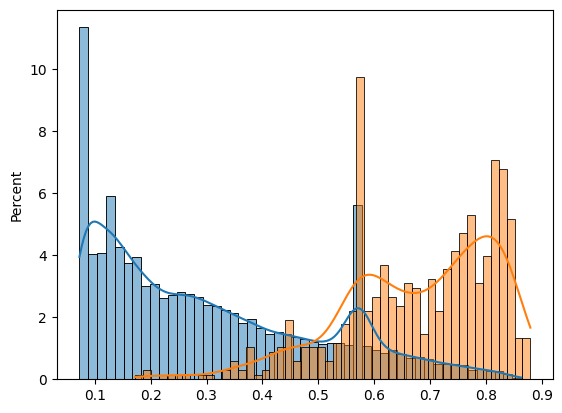

In [23]:
sns.histplot(pred_test[y_test==0], bins=50, stat='percent', kde=True)
sns.histplot(pred_test[y_test==1], bins=50, stat='percent', kde=True)

<Axes: ylabel='Count'>

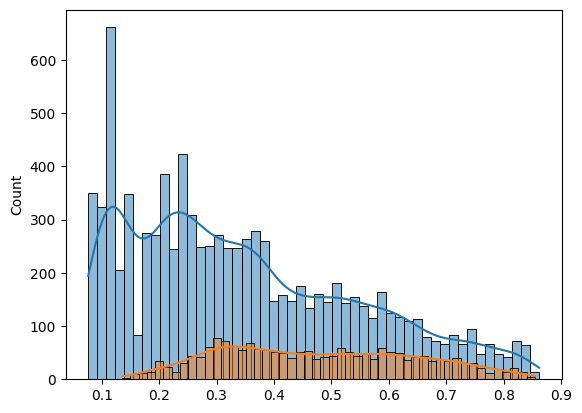

In [24]:
sns.histplot(pred_oot[y_oot==0], bins=50, kde=True)
sns.histplot(pred_oot[y_oot==1], bins=50, kde=True)

In [26]:
additional_data_with_pred_oot = additional_data.loc[x_oot.index].copy()
additional_data_with_pred_oot['pred'] = pred_oot
additional_data_with_pred_oot['y'] = y_oot

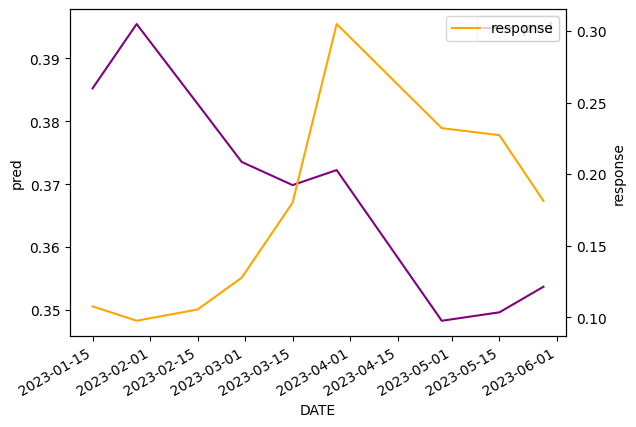

In [27]:
ax = additional_data_with_pred_oot.groupby('DATE').pred.mean().plot(label='pred', color='purple')
plt.legend()
plt.ylabel('pred')


ax3 = ax.twinx()

additional_data_with_pred_oot.groupby('DATE').y.mean().plot(ax=ax3, color='orange', label='response')
plt.ylabel('response')
plt.legend()
#additional_data_with_pred_oot.groupby('DATE').DROUGHT_INDEX.mean().plot(
#    ax=ax2, color='r', linestyle='--', label='actual drough_index'
#)

In [28]:
additional_data_with_pred_oot.groupby('DATE')[['pred', 'y', 'DROUGHT_INDEX']].mean().corr(method='spearman')

,pred,y,DROUGHT_INDEX
pred,1.000000,-0.816667,-0.316667
y,-0.816667,1.000000,0.383333
DROUGHT_INDEX,-0.316667,0.383333,1.000000


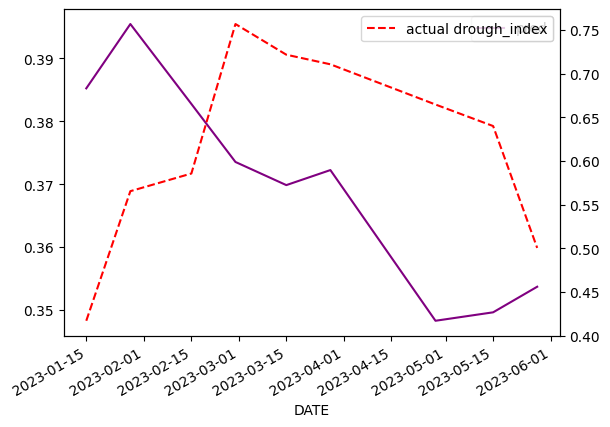

In [29]:
ax = additional_data_with_pred_oot.groupby('DATE').pred.mean().plot(label='pred', color='purple')
plt.legend()

ax3 = ax.twinx()

additional_data_with_pred_oot.groupby('DATE').DROUGHT_INDEX.mean().plot(
    ax=ax3, color='r', linestyle='--', label='actual drough_index'
)
plt.legend()


In [30]:
roc_auc_score(y_oot, pred_oot)

def get_auc(df):
    return roc_auc_score(df.y, df.pred)

<Axes: xlabel='DATE'>

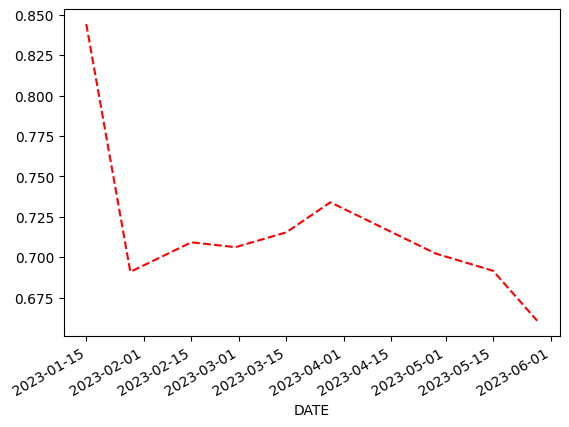

In [31]:
additional_data_with_pred_oot.groupby('DATE').apply(get_auc).plot(linestyle='--', color='r')

In [32]:
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_oot)

Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.


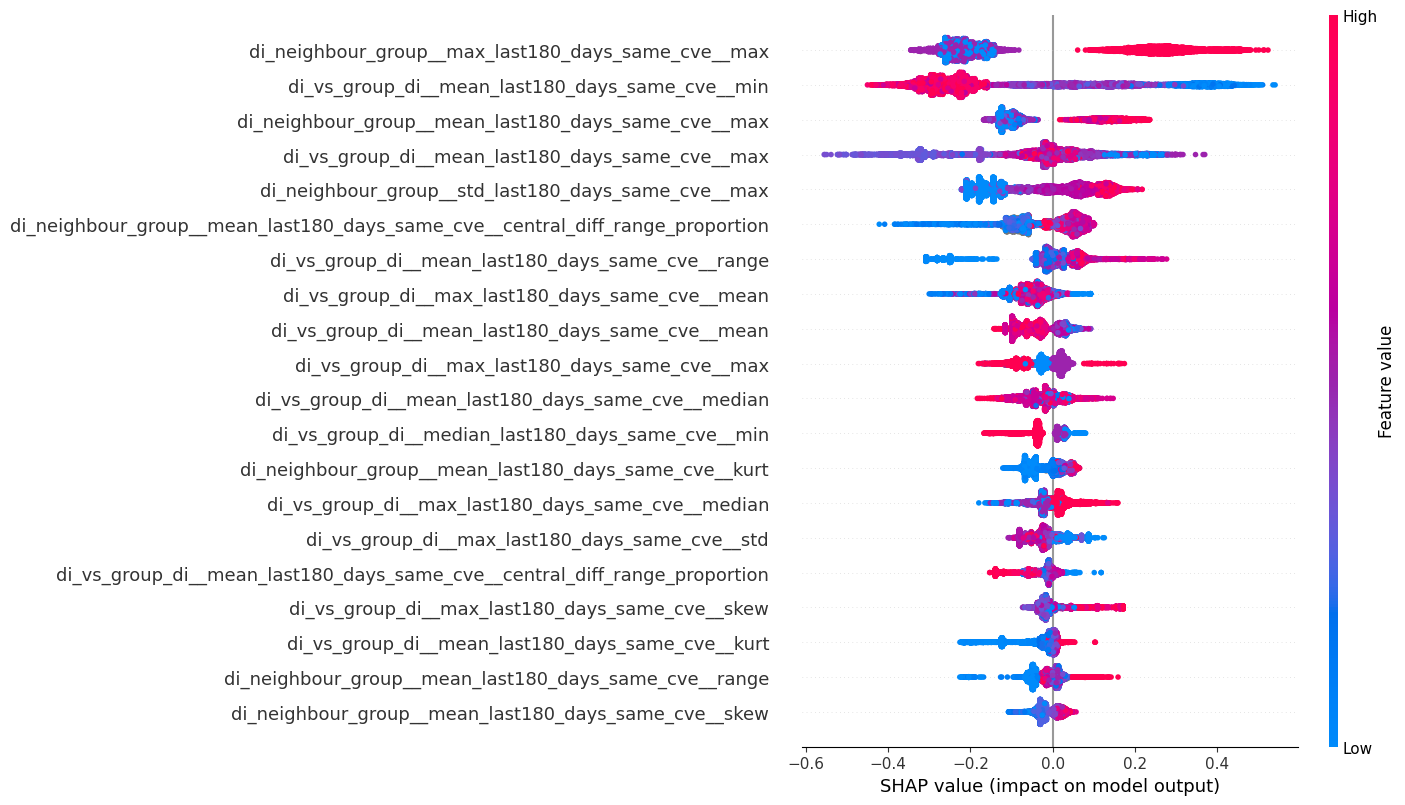

In [33]:
shap.summary_plot(shap_values, x_oot)

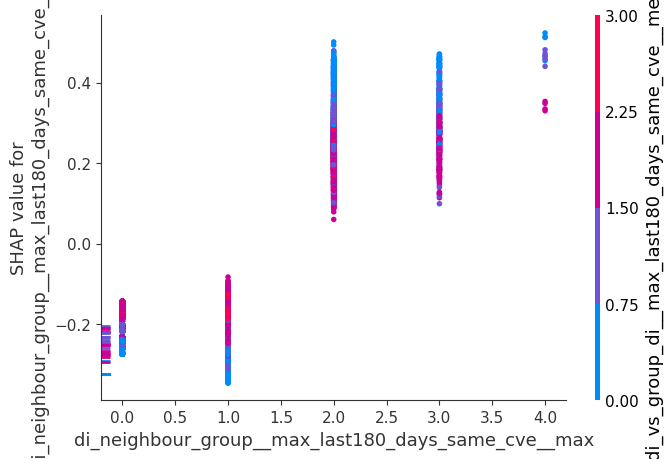

In [37]:
shap.dependence_plot(
    "di_neighbour_group__max_last180_days_same_cve__max", shap_values, x_oot
)


In [38]:
!pip install cxplain


  Preparing metadata (setup.py) ... done
  Created wheel for cxplain: filename=cxplain-1.0.3-py3-none-any.whl size=63476 sha256=d34a1349e7e1441e5a22673b220cdb894bb98f2320c3e785472ecf51cbde367a
  Stored in directory: /home/dhdzmota/.cache/pip/wheels/d2/c1/7a/a9e7c737e42dabf0f788775f4a056b44e4b567b1b63645fd62
Successfully built cxplain

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


In [41]:
from tensorflow.python.keras.losses import categorical_crossentropy
from cxplain import MLPModelBuilder, ZeroMasking, CXPlain
model_builder = MLPModelBuilder(num_layers=2, num_units=64, batch_size=256, learning_rate=0.001)
masking_operation = ZeroMasking()

explainer = CXPlain(explained_model, model_builder, masking_operation, categorical_crossentropy)
explainer.fit(x_oot, y_oot)

# Use the __explainer__ to obtain explanations for the predictions of your __explained_model__.
attributions = explainer.explain(x_oot)

2024-01-11 11:00:52.513896: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 11:00:52.608405: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-01-11 11:00:52.609708: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-11 11:00:54.326320: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


ImportError: cannot import name 'BatchNormalization' from 'tensorflow.python.keras.layers' (/mnt/c/Users/dhdzm/Documents/projects/seguia/venv/lib/python3.8/site-packages/tensorflow/python/keras/layers/__init__.py)

In [40]:
!pip install tensorflow
!pip install cxplain

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 479.6/479.6 MB 1.2 MB/s eta 0:00:0000:0100:18
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 21.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 11.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 12.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 17.2 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 23.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.8/440.8 kB 19.5 MB/s eta 0:00:00
  Using cached typing_extensions-4.5.0-py3-none-any.whl (27

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.9/84.9 kB 1.2 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 151.7/151.7 kB 5.6 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.6.3
    Uninstalling typing_extensions-4.6.3:
      Successfully uninstalled typing_extensions-4.6.3

[notice] A new release of pip is available: 23.1.2 -> 23.3.2
[notice] To update, run: pip install --upgrade pip
